# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [167]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
import LinearModelsPS2_post as lm
import scipy
from tabulate import tabulate
from scipy.stats import chi2
import importlib

In [177]:
# Read data
dat = pd.read_csv('firms.csv')

dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00


In [178]:
# Check if the panel is balanced
N = dat.firmid.nunique()
T = dat.year.nunique()
assert dat.shape[0] == N * T, f'Error: data is not a balanced panel'

# Convert data to panel structure
dat = dat.set_index(['firmid', 'year'])

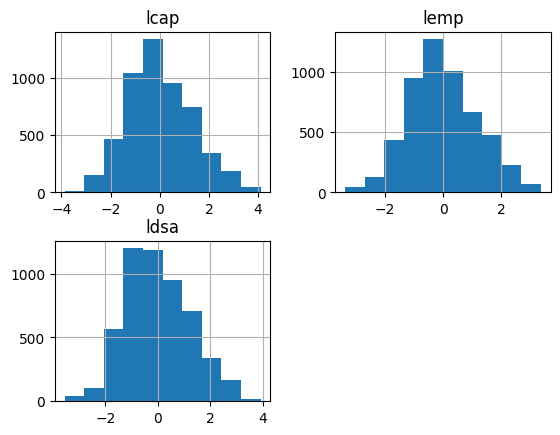

In [179]:
# Visualiseringer
dat[['lcap', 'lemp', 'ldsa']].hist()
plt.show()

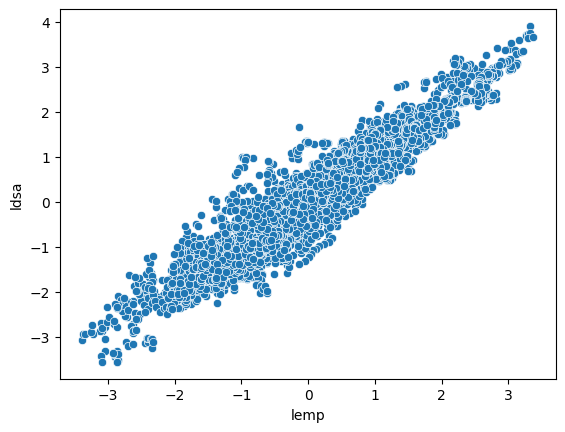

In [171]:
sns.scatterplot(x='lemp', y='ldsa', data=dat)
plt.show()

In [180]:
dat.sample(5) 

,,lcap,lemp,ldsa
firmid,year,,,
297,1975,0.665836,0.225096,0.224075
219,1972,-1.285900,-0.916663,-0.789638
247,1978,-0.491827,-0.290395,-0.609127
335,1977,3.639828,2.199550,3.117482
310,1978,-1.504910,-1.055110,-1.339390


In [181]:
dat.year.unique()

AttributeError: 'DataFrame' object has no attribute 'year'

# Descriptives

In [174]:
dat.describe()

,lcap,lemp,ldsa
count,5.292000e+03,5.292000e+03,5.292000e+03
mean,-7.125472e-09,-1.252834e-08,4.695767e-09
std,1.310973e+00,1.180122e+00,1.232499e+00
min,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,9.063340e-01,7.930060e-01,8.562296e-01
max,4.103687e+00,3.371332e+00,3.913391e+00


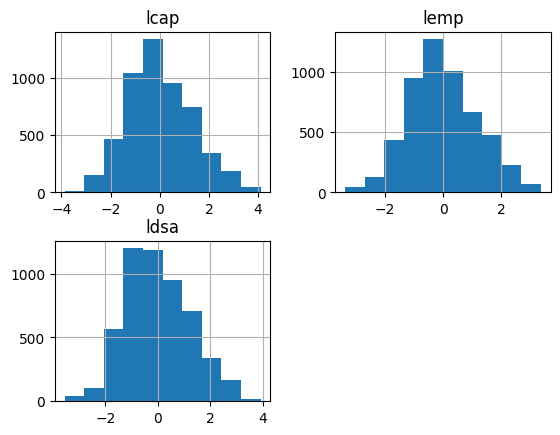

In [175]:
dat[['lcap','lemp','ldsa']].hist();

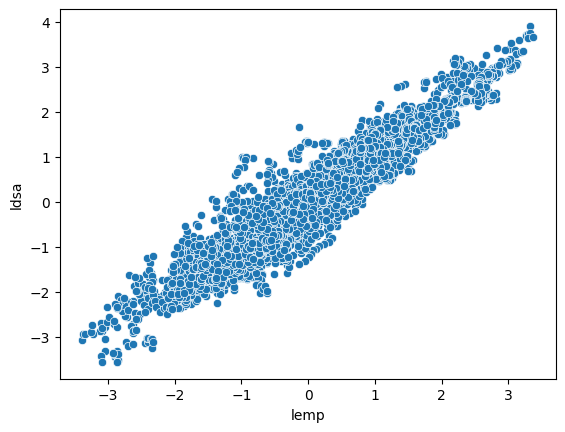

In [162]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 

# Converting data to numpy format 

In [163]:
dat.ldsa.values.shape

(5292,)

In [164]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

AttributeError: 'DataFrame' object has no attribute 'firmid'

Extract data from `pandas` to `numpy` arrays. 

In [ ]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])

xlbl = ["constant", "lcap", "lemp"]
ylbl = ["ldsa"]

**Pooled OLS**

In [ ]:

importlib.reload(lm) 


<module 'LinearModelsPS2_post' from 'c:\\Users\\imvaa\\OneDrive\\Skrivebord\\EconometricsB-aflevinger\\LinearModelsPS2_post.py'>

In [ ]:
#Pooled OLS
estimation_POLS = lm.estimate(y, X, transform='', T=T, robust_se=True)

lm.print_table((ylbl, xlbl), estimation_POLS, title="POLS")

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0

C_OLS = np.array([[0,1,1]])
cov_m_OLS = estimation_POLS["cov"]
betas_OLS = estimation_POLS["b_hat"]
wald_OLS = (C_OLS @ betas_OLS).T @ np.linalg.inv((C_OLS @ cov_m_OLS @ C_OLS.T)) @ (C_OLS @ betas_OLS)

p_value_OLS = 1 - scipy.stats.chi2.cdf(wald_OLS, 1)
print("Wald test statistic: ", wald_OLS[0][0])
print("p-value: ", p_value_OLS[0][0])

POLS
Dependent variable: ['ldsa']

                 Beta         Se      t-values
--------  -----------  ---------  ------------
constant  3.84116e-08  0.0165836   2.31624e-06
lcap      0.686033     0.0348063  19.71
lemp      0.276809     0.0306765   9.02351
R² = 0.917
σ² = 0.127
Wald test statistic:  5936.259586263398
p-value:  0.0


**FE estimation**

In [147]:
#FE estimation
def demeaning_matrix(T):
    Q_T = np.eye(T) - np.tile(1/T, (T, T))
    return Q_T

Q_T = demeaning_matrix(T)
y_demean = lm.perm(Q_T, y)
x_demean = lm.perm(Q_T, X)
x_demean = x_demean[:, 1:]

estimation_FE = lm.estimate(y_demean, x_demean, T=T, transform="fe", robust_se=True)
lm.print_table((ylbl, xlbl[1:]), estimation_FE, title="FE")

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0
C_FE = np.array([[1,1]])
cov_m_FE = estimation_FE["cov"]
betas_FE = estimation_FE["b_hat"]
wald_FE = (C_FE @ betas_FE).T @ np.linalg.inv((C_FE @ cov_m_FE @ C_FE.T)) @ (C_FE @ betas_FE)

p_value_FE = 1 - scipy.stats.chi2.cdf(wald_FE, 1)
print("Wald test statistic: ", wald_FE[0][0])
print("p-value: ", p_value_FE[0][0])

FE
Dependent variable: ['ldsa']

          Beta         Se    t-values
----  --------  ---------  ----------
lcap  0.661934  0.0403993    16.3848
lemp  0.292968  0.036053      8.12604
R² = 0.892
σ² = 0.113
Wald test statistic:  3616.8752874623533
p-value:  0.0


**FD Estimation**

In [ ]:
def fd_matrix(T):
    D_T = np.eye(T) - np.eye(T, k=-1)
    D_T = D_T[1:]
    return D_T

D_T = fd_matrix(T)
y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T, X)
x_diff = x_diff[:, 1:]

estimation_FD = lm.estimate(y_diff, x_diff, T=T-1, robust_se=True)
lm.print_table((ylbl, xlbl[1:]), estimation_FD, title="FD")

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0
C_FD = np.array([[1,1]])
cov_m_FD = estimation_FD["cov"]
betas_FD = estimation_FD["b_hat"]
wald_FD = (C_FD @ betas_FD).T @ np.linalg.inv((C_FD @ cov_m_FD @ C_FD.T)) @ (C_FD @ betas_FD)

p_value_FD = 1 - scipy.stats.chi2.cdf(wald_FD, 1)
print("Wald test statistic: ", wald_FD[0][0])
print("p-value: ", p_value_FD[0][0])

FD
Dependent variable: ['ldsa']

           Beta         Se    t-values
----  ---------  ---------  ----------
lcap  0.550946   0.0497416   11.0762
lemp  0.0381129  0.0457618    0.832854
R² = 0.217
σ² = 0.013
Wald test statistic:  95.85643199259546
p-value:  0.0


**RE Estimation**

In [148]:
#First doint the between estimation
def mean_matrix(t):
    return np.tile(1/t, (1, t))
P_T = mean_matrix(T)
y_mean_BE = lm.perm(P_T, y)
x_mean_BE = lm.perm(P_T, X)

estimation_BE = lm.estimate(
    y_mean_BE, x_mean_BE, transform='be')

lm.print_table((ylbl, xlbl), results=estimation_BE, title='BE')

BE
Dependent variable: ['ldsa']

                 Beta         Se    t-values
--------  -----------  ---------  ----------
constant  0.000245711  0.014739    0.0166708
lcap      0.761383     0.0612711  12.4265
lemp      0.217748     0.0540843   4.02609
R² = 0.959
σ² = 0.024


In [149]:
#Calculating lambda
sigma_u = estimation_FE['sigma2']
sigma_c = estimation_BE['sigma2'] - sigma_u/T
_lambda = 1 - np.sqrt(sigma_u/(sigma_u + T*sigma_c))
print(_lambda)

0.37199604768230676


In [150]:
#Doing random effects
C_t = np.eye(T) - _lambda*mean_matrix(T)
x_re = lm.perm(C_t, X)
y_re = lm.perm(C_t, y)
estimation_RE = lm.estimate(y_re, x_re, transform='re', T=T)
lm.print_table((ylbl, xlbl), results=estimation_RE, _lambda=_lambda,title='RE')

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0
C_RE = np.array([[0,1,1]])
cov_m_RE = estimation_RE["cov"]
betas_RE = estimation_RE["b_hat"]
wald_RE = (C_RE @ betas_RE).T @ np.linalg.inv((C_RE @ cov_m_RE @ C_RE.T)) @ (C_RE @ betas_RE)

p_value_RE = 1 - scipy.stats.chi2.cdf(wald_RE, 1)
print("Wald test statistic: ", wald_RE[0][0])
print("p-value: ", p_value_RE[0][0])

RE
Dependent variable: ['ldsa']

                 Beta         Se    t-values
--------  -----------  ---------  ----------
constant  0.000361403  0.0147416   0.0245159
lcap      0.672681     0.0197849  33.9998
lemp      0.285912     0.0175381  16.3024
R² = 0.905
σ² = 0.113
λ = 0.372
Wald test statistic:  12137.427734030356
p-value:  0.0


In [151]:
#HAUSMAN TEST
b_re = estimation_RE['b_hat']
b_re = b_re[1:]

hat_diff = estimation_FE['b_hat'] - b_re

cov_re = estimation_RE['cov']
cov_re = cov_re[1:,1:]

cov_diff = estimation_FE['cov'] - cov_re
H = hat_diff.T@np.linalg.inv(cov_diff)@hat_diff

p_val = chi2.sf(H.item(), 4)

def print_h_test(fe_result, re_result, hat_diff, p_val):
    table = []
    for i in range(len(hat_diff)):
        row = [
            fe_result['b_hat'][i], re_result['b_hat'][1:][i], hat_diff[i]
        ]
        table.append(row)

    print(tabulate(
        table, headers=['b_fe', 'b_re', 'b_diff'], floatfmt='.4f'
        ))
    print(f'The Hausman test statistic is: {H.item():.2f}, with p-value: {p_val:.2f}.')
print_h_test(estimation_FE, estimation_RE, hat_diff, p_val)

  b_fe    b_re    b_diff
------  ------  --------
0.6619  0.6727   -0.0107
0.2930  0.2859    0.0071
The Hausman test statistic is: 0.12, with p-value: 1.00.


In [ ]:
#Test for exogeneity

def exogeneity_test(x, y, T):
    # Create lead
    F_T = np.eye(T, k=1)
    F_T = F_T[:-1]

    # Lead firm with capital and labor
    labor_lead = lm.perm(F_T, x[:, 2].reshape(-1, 1))
    capital_lead = lm.perm(F_T, x[:, 1].reshape(-1, 1))
    
    # Collect variables to test for exogeneity
    x_exo = np.delete(x, np.s_[2::3], axis=0)
    x_exo = np.hstack((x_exo, labor_lead))
    x_exo = np.hstack((x_exo, capital_lead))
    y_exo = np.delete(y, np.s_[2::3], axis=0)

    # Within transform the data
    Q_T = fd_matrix(T - 1)

    yw_exo = lm.perm(Q_T, y_exo)
    xw_exo = lm.perm(Q_T, x_exo)
    xw_exo = xw_exo[:, 1:]

    label_exo = xlbl[1:] + ['Labor lead'] + ["Capital lead"]
    n = y.size/T
    # Estimate model
    exo_test = lm.estimate(
        yw_exo, xw_exo, T=T - 1, transform='fd'
    )

    lm.print_table(
        (ylbl, label_exo), 
        exo_test, title='Exogeneity test', floatfmt='.4f'
    )
    return exo_test
exo_test = exogeneity_test(X, y, T)

Exogeneity test
Dependent variable: ['ldsa']

                Beta      Se    t-values
------------  ------  ------  ----------
lcap          0.4599  0.0550      8.3615
lemp          0.0580  0.0674      0.8617
Labor lead    0.0656  0.0702      0.9342
Capital lead  0.1552  0.0504      3.0768
R² = 0.221
σ² = 0.013


In [ ]:
#WALD TEST for exogeneity
#Test whether the values of beta for Labor lead and Capital lead are 0.
#H_0=B_3=B_4=0
#H_A=B_3!=B_4!=0


C = np.array([[0,0,1,0], [0,0,0,1]])
cov_m = exo_test["cov"]
betas = exo_test["b_hat"]
wald = (C @ betas).T @ np.linalg.inv((C @ cov_m @ C.T)) @ (C @ betas)


p_value = 1 - scipy.stats.chi2.cdf(wald, 2)
print("Wald test statistic: ", wald[0][0])
print("p-value: ", p_value[0][0])
#Since below 0,05 (on a 95% confidensinterval), we reject H_0. And we therefore dont have strict exogeneity.
#If we look at it with 0,01 (on a 99% confidensinterval), we cannot reject H_0 and can therefore make it plausible that we have strict exogeneity.

Wald test statistic:  11.190527190829329
p-value:  0.0037154198387742143


In [ ]:
def serial_corr(y, x, T):
    b_hat = lm.est_ols(y, x)
    
    e = y - x@b_hat
    # Create a lag to estimate the error on.
    L_T = np.eye(T, k=-1)
    L_T = L_T[1:]

    e_l = lm.perm(L_T, e)

    # We then need to remove the first obs for every person again.
    reduced_year = dat[dat["year"] != 1968]["year"]
    e = e[reduced_year != 1969]
    return lm.estimate(e, e_l,T=T-1)
corr_result = serial_corr(y_diff, x_diff, T-1)

label_ye = 'OLS residual, e\u1d62\u209c'
label_e = ['e\u1d62\u209c\u208B\u2081']
title = 'Serial Correlation'
lm.print_table(
    (label_ye, label_e), corr_result, 
    title='Serial Correlation', floatfmt='.4f'
)

Serial Correlation
Dependent variable: OLS residual, eᵢₜ

          Beta      Se    t-values
-----  -------  ------  ----------
eᵢₜ₋₁  -0.1849  0.0483     -3.8295
R² = 0.032
σ² = 0.013
